<a href="https://colab.research.google.com/github/srirangamuc/Network-Intrusion-Detection-using-Autoencoders/blob/main/Network_Intrusion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('data.csv')

In [ ]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

In [ ]:
df.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [ ]:
df.duplicated().sum()

0

In [ ]:
X = df.drop(columns=['class'])
y = df['class'].apply(lambda x:1 if x == 'anomaly' else 0)

In [ ]:
y

0        0
1        0
2        1
3        0
4        0
        ..
25187    1
25188    1
25189    1
25190    1
25191    1
Name: class, Length: 25192, dtype: int64

In [ ]:
categorical_features = ['protocol_type','service','flag']
numerical_features = [col for col in X.columns if col not in categorical_features]

In [ ]:
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
data_preprocessor = ColumnTransformer(
    transformers = [
        ('num',StandardScaler(),numerical_features),
        ('cat',OneHotEncoder(handle_unknown='ignore'),categorical_features)
    ])

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
X_train_transformed = data_preprocessor.fit_transform(X_train)
X_test_transformed = data_preprocessor.transform(X_test)

In [ ]:
X_train_normal = X_train_transformed[y_train == 0]

In [ ]:
## Autoencoder Model
input_dimn = X_train_normal.shape[1]
encoding_dimn =14
input_layer = Input(shape=(input_dimn,))

enc = Dense(encoding_dimn,activation='relu')(input_layer)
enc = Dense(7,activation='relu')(enc)
latent_space = Dense(4,activation="relu")(enc)
dec = Dense(7,activation="relu")(latent_space)
dec = Dense(encoding_dimn,activation="relu")(dec)
output_layer = Dense(input_dimn,activation="sigmoid")(dec)

# Compile the model
autoencoder = Model(inputs = input_layer,outputs = output_layer)
autoencoder.compile(optimizer='adam',loss = 'mean_squared_error')

#Train the model
autoencoder.fit(X_train_normal,
                X_train_normal,
                epochs=50,
                batch_size=32,
                shuffle=True,
                validation_split=0.1)

Epoch 1/50
304/304 [==============================] - 2s 3ms/step - loss: 0.3228 - val_loss: 0.2181
Epoch 2/50
304/304 [==============================] - 1s 3ms/step - loss: 0.2512 - val_loss: 0.2065
Epoch 3/50
304/304 [==============================] - 1s 3ms/step - loss: 0.2410 - val_loss: 0.2011
Epoch 4/50
304/304 [==============================] - 1s 3ms/step - loss: 0.2367 - val_loss: 0.1979
Epoch 5/50
304/304 [==============================] - 1s 2ms/step - loss: 0.2329 - val_loss: 0.1936
Epoch 6/50
304/304 [==============================] - 1s 2ms/step - loss: 0.2294 - val_loss: 0.1898
Epoch 7/50
304/304 [==============================] - 1s 2ms/step - loss: 0.2264 - val_loss: 0.1869
Epoch 8/50
304/304 [==============================] - 1s 2ms/step - loss: 0.2242 - val_loss: 0.1860
Epoch 9/50
304/304 [==============================] - 1s 2ms/step - loss: 0.2236 - val_loss: 0.1857
Epoch 10/50
304/304 [==============================] - 1s 2ms/step - loss: 0.2232 - val_loss: 0.1848

In [ ]:
X_test_predictions = autoencoder.predict(X_test_transformed)

158/158 [==============================] - 1s 4ms/step


In [ ]:
mse = np.mean(np.power(X_test_transformed-X_test_predictions,2),axis=1)

In [ ]:
print(mse)

[0.12065623 0.10726613 0.2026393  ... 0.0375414  0.04251475 0.03384436]


In [ ]:
fpr,tpr,thresholds = roc_curve(y_test,mse)
roc_auc = auc(fpr,tpr)

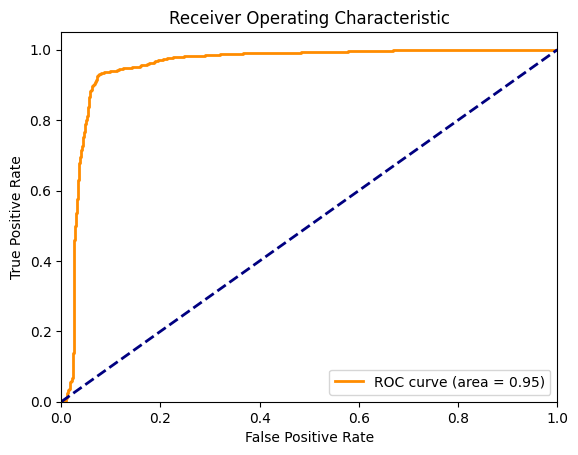

AUC score: 0.9525916309430251


In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC score:", roc_auc)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support,confusion_matrix

threshold = 0.1
y_pred = mse > threshold

precision,recall,f1,_ = precision_recall_fscore_support(y_test,y_pred,average='binary')

# Print precision, recall, and F1-score
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Precision: 0.7983
Recall: 0.9772
F1-Score: 0.8787
Confusion Matrix:
[[2090  584]
 [  54 2311]]
